## Empirical comparison of static routing algorithms
### Usage example: Odd-even and greedy comparison (line network)

#### Installation:
1. Clone repo: git clone https://github.com/efectivo/network_sim
2. Install anaconda: https://www.continuum.io/downloads
3. cd network_sim
4. Run this code

In [1]:
# Import necessary modules.
from units import environment, tested_unit, patterns, packet, test_reporter
from protocols import greedy, down_hill, forwarding_protocol, forwarding_buffer
import networkx as nx
import random
import sys
import logging
import matplotlib.pyplot as plt
%matplotlib inline

http://networkx.readthedocs.io/en/networkx-1.10/
The nodes:
[0, 1, 2, 3, 4]

The edges (direct graph):
[(0, 1), (1, 2), (2, 3), (3, 4)]

Graph algorithms (in this case all shortest paths):
{0: {0: [0], 1: [0, 1], 2: [0, 1, 2], 3: [0, 1, 2, 3], 4: [0, 1, 2, 3, 4]}, 1: {1: [1], 2: [1, 2], 3: [1, 2, 3], 4: [1, 2, 3, 4]}, 2: {2: [2], 3: [2, 3], 4: [2, 3, 4]}, 3: {3: [3], 4: [3, 4]}, 4: {4: [4]}}

Drawing the network:



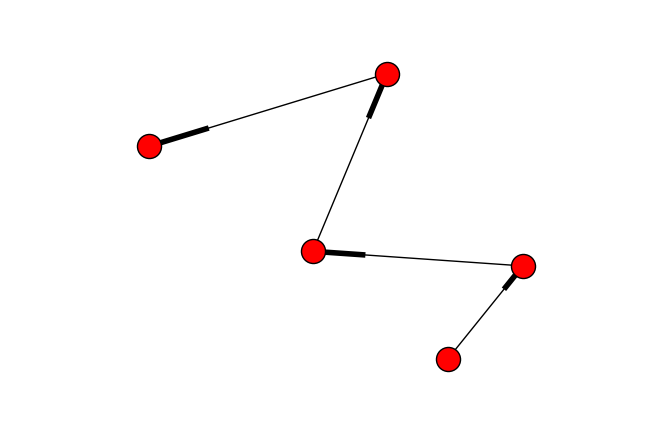

In [9]:
# Define the network - in this case a directed line
# We use Networkx library. It contains many helpful functions:
print 'http://networkx.readthedocs.io/en/networkx-1.10/'
N = 5
net = nx.DiGraph()
for i in xrange(N-1):
    net.add_edge(i, i+1)

print 'The node names:'
print net.nodes()
print 
print 'The edges (direct graph):'
print net.edges()
print 
print 'Graph algorithms (in this case all shortest paths):'
print nx.shortest_path(net)
print 
print 'Drawing the network:'
nx.draw(net)
print 

In [3]:
# Create adversary, injection patterns by implementing the pattern interface
class line_random_src_random_dst_pattern(patterns.PatternIfc):
    def __init__(self, net, node_num):
        patterns.PatternIfc.__init__(self, net)
        self.node_num = node_num

    def invoke(self, curr_cycle):
        # Randomize source and destination nodes.
        src = random.randrange(self.node_num)
        dst = random.randrange(self.node_num)
        
        # If the least is empty, no packets will be injected on this cycle
        if src == dst:
            return []
        
        src, dst = min(src, dst), max(src, dst)
        route = range(src, dst+1)
        # Return a list of packets. In this case only one. 
        # The packet is defined by its route (which contains the src and dst nodes)
        return [packet.Packet('RSRD', route, curr_cycle)]

In [4]:
# Now the setup is almost ready, let's create a setup object:
cycle_number = 1000
pattern = line_random_src_random_dst_pattern(net, N)
# The setup may contain multiple injection patterns
setup = environment.EnvironmentSetup(net, [pattern], cycle_number=cycle_number, log_level=logging.INFO)

In [5]:
# Here we show an example of creating a simple forwarding protocol.
# Some protocols are already defined in the protocols folder. 
class GreedyProtocol(forwarding_protocol.ForwardingProtocol):
    # Note that the argument is the buffer type (LIS by default). 
    # The simulation holds a copy of the entire network buffers for each tested protocol.
    def __init__(self, buffer_type=forwarding_buffer.LongestInSystem):
        forwarding_protocol.ForwardingProtocol.__init__(self, buffer_type)

    # Here is were nodes communicate with one another. 
    # The results of this step are stored in dictionary called to_send in order to keep the buffers 
    # constant throughout the communication step.
    def run_communication_step(self):
        self.to_send = {}
        for node in self.nodes.itervalues():
            self._run_communication_step_per_node(node)

    def _run_communication_step_per_node(self, node):
        for parent in node.parents:
            buf = parent.buffers[node.name]
            buf_size = len(buf)
            if buf_size == 0:
                continue
            send_count = min(buf_size, node.edge_capacity_per_parent[parent.name])
            self.to_send[parent, node.name] = send_count

    # Here is were the protcol extract packets from a node buffers and pass it the next node
    def run_forwarding_step(self):
        for (node, next_node_name), buf_len in self.to_send.iteritems():
            node.send(next_node_name, buf_len)

In [6]:
# Let define two tested protocols, one is the above greedy and the odd even
test1 = tested_unit.Test('greedy', GreedyProtocol(), reporter=test_reporter.TestResultsHistory('demo1_greedy_history.h5'))
test2 = tested_unit.Test('downhill', down_hill.DownHillProtocol(use_odd_even=True))
tests = [test1, test2]

In [7]:
# In INFO log level, the results will be printed to the screen
env = environment.Environment(setup, tests)
env.run()

INFO:greedy_results:Total sent: 794
INFO:greedy_results:Total recv: 794
INFO:greedy_results:Average packet delay: 0.243073047859
INFO:greedy_results:Max packet delay: 2
INFO:greedy_results:Max buffer size: 3
INFO:greedy_results:Max delay factor: 3.0
INFO:greedy_results:Average delay factor: 1.12308673469
INFO:downhill_results:Total sent: 794
INFO:downhill_results:Total recv: 794
INFO:downhill_results:Average packet delay: 0.278337531486
INFO:downhill_results:Max packet delay: 4
INFO:downhill_results:Max buffer size: 2
INFO:downhill_results:Max delay factor: 4.0
INFO:downhill_results:Average delay factor: 1.14094387755


In [8]:
# The results can be access using the reporter object
print test1.reporter.max_buffer_size

3
